In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from eval_class import *
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.8.1
pandas==2.1.1
numpy==1.26.0
seaborn==0.13.0


In [3]:
df = pd.read_csv(r'C:\Users\Sharif\Downloads\Compressed\data_mining_test_Project\Data.csv')
df=df.drop(['Unnamed: 0'],axis=1)
df=df.drop(['signal'],axis=1)
df.head()

,Date,Open,High,Low,Close,v_i_buy,v_n_buy,v_i_sell,v_n_sell,n_i_buy,n_n_buy,n_i_sell,n_n_sell,f1,f2,f3,f4,f5,f6
0,20110711,12500,12500,12500,12500,30320681.0,89389319.0,0.0,119710000.0,5736.0,166.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20110712,12610,12940,12511,12513,839652.0,2603130.0,3327282.0,115500.0,237.0,9.0,1153.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20110713,12515,12685,12501,12502,305908.0,6485132.0,6324540.0,466500.0,49.0,9.0,986.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20110719,12629,12629,12500,12501,98549.0,1580602.0,1578151.0,101000.0,26.0,3.0,261.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20110720,12501,12515,12500,12500,104577.0,2076431.0,1822008.0,359000.0,10.0,2.0,303.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
Predict_price_train = pd.read_csv(r'Predict_price_train.csv')
Predict_price_valid = pd.read_csv(r'Predict_price_valid.csv')

In [7]:
Predict_price_train

,Close_pred,close
0,12114.414,12500
1,12113.396,12500
2,12113.257,12500
3,12113.564,12490
4,12111.791,12350
...,...,...
1887,91606.945,103391
1888,95065.970,107117
1889,99141.080,111480
1890,103581.060,117054


In [4]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [18]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 1869.200000
iter 20. reward: 1806.860000
iter 30. reward: 2114.730000
iter 40. reward: 4558.560000
iter 50. reward: 4290.070000
iter 60. reward: 6111.010000
iter 70. reward: 5319.810000
iter 80. reward: 6457.190000
iter 90. reward: 7259.490000
iter 100. reward: 8211.110000
iter 110. reward: 10194.020000
iter 120. reward: 13962.590000
iter 130. reward: 13049.000000
iter 140. reward: 14671.510000
iter 150. reward: 13501.530000
iter 160. reward: 14439.450000
iter 170. reward: 17048.780000
iter 180. reward: 17196.140000
iter 190. reward: 18831.210000
iter 200. reward: 17074.630000
iter 210. reward: 16963.980000
iter 220. reward: 16700.670000
iter 230. reward: 17924.730000
iter 240. reward: 19365.320000
iter 250. reward: 19116.890000
iter 260. reward: 19247.340000
iter 270. reward: 18863.780000
iter 280. reward: 20199.810000
iter 290. reward: 20961.640000
iter 300. reward: 21152.840000
iter 310. reward: 22250.560000
iter 320. reward: 21364.650000
iter 330. reward: 21385.770

In [19]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 234: buy 1 unit at price 9101.000000, total balance 899.000000
day 238, sell 1 unit at price 8345.000000, investment -8.306779 %, total balance 9244.000000,
day 241: buy 1 unit at price 8100.000000, total balance 1144.000000
day 243, sell 1 unit at price 8610.000000, investment 6.296296 %, total balance 9754.000000,
day 246: buy 1 unit at price 8300.000000, total balance 1454.000000
day 248, sell 1 unit at price 8828.000000, investment 6.361446 %, total balance 10282.000000,
day 249: buy 1 unit at price 8700.000000, total balance 1582.000000
day 250, sell 1 unit at price 8699.000000, investment -0.011494 %, total balance 10281.000000,
day 253: buy 1 unit at price 9090.000000, total balance 1191.000000
day 264, sell 1 unit at price 10835.000000, investment 19.196920 %, total balance 12026.000000,
day 265: buy 1 unit at price 10540.000000, total balance 1486.000000
day 276, sell 1 unit at price 11545.000000, investment 9.535104 %, total balance 13031.000000,
day 277: buy 1 unit at pr

In [20]:
Signal=[]
for i in range(len(df)):
    if i in states_buy:
        Signal.append(-1)
    elif i in states_sell:
        Signal.append(1)
    else:
        Signal.append(0)
datas={
    "signal":Signal,
    "close":df.Close.tolist(),
    "Date":df.Date.tolist() 
}
sample_eval=pd.DataFrame(datas)

In [22]:
a=0
for i in range(len(sample_eval)):
    if a == 1 and sample_eval.signal[i] == 1 or a == -1 and sample_eval.signal[i] == -1:
        sample_eval.signal[i] = 0
    elif a == -1 and sample_eval.signal[i] == 1 or a == 1 and sample_eval.signal[i] == -1:
        a = sample_eval.signal[i]
    elif a == 0 and sample_eval.signal[i] == -1:
        a = sample_eval.signal[i]
    elif a == 0 and sample_eval.signal[i] == 1:       
        sample_eval.signal[i] = 0

C:\Users\Sharif\AppData\Local\Temp\ipykernel_25400\2331136499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_eval.signal[i] = 0
C:\Users\Sharif\AppData\Local\Temp\ipykernel_25400\2331136499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_eval.signal[i] = 0
C:\Users\Sharif\AppData\Local\Temp\ipykernel_25400\2331136499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_eval.signal[i] = 0
C:\Users\Sharif\App

In [23]:
profit, win_rate = eval_strategy(sample_eval)
print("profit:", profit,"\nwin_rate:", win_rate)

profit: 6.315 
win_rate: 0.5257


In [42]:
profit, win_rate = eval_strategy(sample_eval)
print("profit:", profit,"\nwin_rate:", win_rate)

profit: 8.5469 
win_rate: 0.5952


In [17]:
import finplot as fplt

# CREATE A TICKER INSTANCE FOR TESLA
#Rasad = yf.Ticker('TSLA')

# RETRIEVE 1 YEAR WORTH OF DAILY DATA OF TESLA
#df = Rasad.history(interval='1d',period='1y')

# PLOT THE OHLC CANDLE CHART
aa=df[['Open','Close','High','Low','Date']]
aa=sample_eval.merge(aa, left_on='Date', right_on='Date')

fplt.candlestick_ochl(aa[['Open','Close','High','Low']])
#train1['AdaBoostClassifier']=sample_eval_AdaBoot['signal']
lo_wicks=aa['signal']
aa.loc[(lo_wicks==1),'marker'] = aa['Close']
fplt.plot(aa.index, aa['marker'],color='navy', style='^', legend='dumb mark')
aa.loc[(lo_wicks==-1),'marker1'] = aa['Close']
fplt.plot(aa.index, aa['marker1'],color='lawngreen', style='v', legend='dumb mark')

#fplt.plot(a , color='black', legend='Log price')
fplt.show()

 - Assuming time column is missing and using index instead.


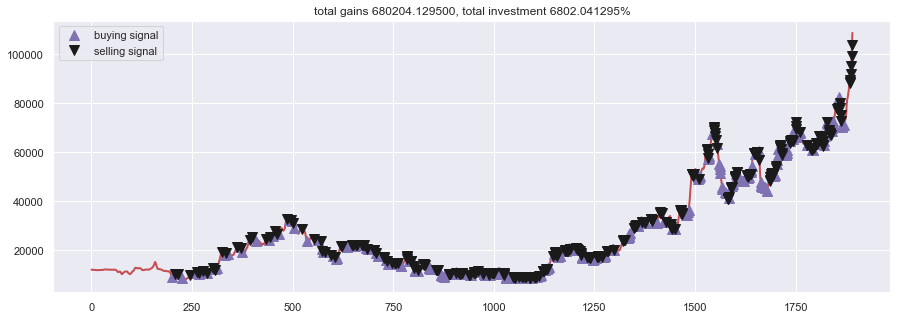

In [10]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [22]:
Predict_price_train

,Close_pred,close
0,12114.414,12500
1,12113.396,12500
2,12113.257,12500
3,12113.564,12490
4,12111.791,12350
...,...,...
1887,91606.945,103391
1888,95065.970,107117
1889,99141.080,111480
1890,103581.060,117054
